In [1]:
import sys
sys.path.append('../')

# Diving into scans-preprocessing with RadIO

## Quick reminder

Hello again! This is the second tutorial in the series, dedicated to the lung cancer research with RadIO. In the [first notebook](https://github.com/analysiscenter/radio/blob/master/tutorials/RadIO.I.ipynb) we talked about using RadIO to create a `Dataset` of scans from [LUNA16 competition dataset](https://luna16.grand-challenge.org/). In short, `Dataset` simplifies operating with large datasets that cannot fit in memory (see more [here](https://github.com/analysiscenter/dataset)). Setting up a `Dataset` takes only several lines of code:

In [2]:
from radio.dataset import FilesIndex, Dataset
from radio import CTImagesMaskedBatch

LUNA_MASK = '/data/MRT/luna/s*/*.mhd'                     # set glob-mask for scans from Luna-dataset here
luna_index = FilesIndex(path=LUNA_MASK, no_ext=True)      # preparing indexing structure
luna_dataset = Dataset(index=luna_index, batch_class=CTImagesMaskedBatch)

We've also seen how easy it is to build simple preprocessing pipelines, that include `load` of data from disk and `resize` of scans to differrent shape:

In [3]:
from radio.dataset import Pipeline
preprocessing = (Pipeline()                      # initialize empty workflow
                 .load(fmt='raw')                # add load of scans from MetaImage to the workflow
                 .resize(shape=(92, 256, 256)))  # add resize to a shape to the workflow. Nothing is computed here,
                                                 # the whole thing is lazy!

..and generate a batch with 3 loaded and resized scans: 

In [4]:
batch = (luna_dataset >> preprocessing).next_batch(3)  # pass a batch of luna-scans of size 3 through the workflow 

In this tutorial we are diving deeper into preprocessing with RadIO. We will cover actions that allow to considerably augment Luna-dataset. `unify_spacing`, `rotate`, `central_crop` are among actions, that help to perform augmentation. What's more, we will cover actions `create_mask` and `fetch_nodules_info`, that will help you to transform with ease [Luna cancer annotations](https://luna16.grand-challenge.org/download/) into *cancerous masks*, **target (Y)** for segmenting nets (think of [VNet](https://arxiv.org/abs/1606.04797)).

## Augmentation of Luna


###  `unify_spacing`: alternative to `resize`

Not infrequently, scans in the dataset have drastically different scales. Take a look at two slices from different scans below: 

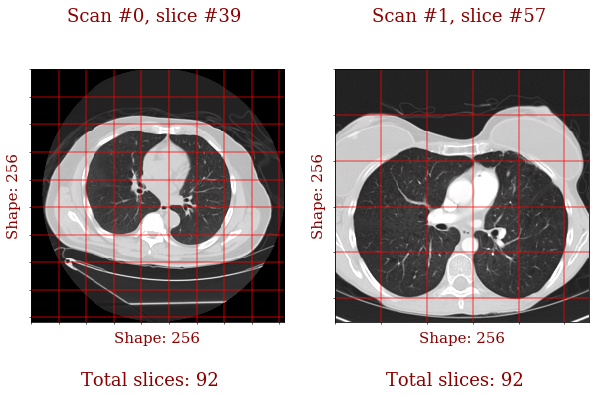

In [5]:
from utils import show_slices
import numpy as np
ixs = np.array(['1.3.6.1.4.1.14519.5.2.1.6279.6001.219618492426142913407827034169',
                '1.3.6.1.4.1.14519.5.2.1.6279.6001.185154482385982570363528682299'])
two_scans_dataset = Dataset(index=luna_index.create_subset(ixs), batch_class=CTImagesMaskedBatch)
batch = (two_scans_dataset >> preprocessing).next_batch(2, shuffle=False)   # pass a batch through the workflow
show_slices(batch, scan_indices=[0, 1], ns_slice=[39, 57], grid=True)

As you can see, lungs on the right scan are clearly bigger than on the left one. In this case you may say that left and right scans have different **spacings**: the distance between adjacent pixels on the left scan is larger than on the right one. This is demonstrated by grids on both plots: the number of pixels to define 5 cm of the real-world distance is lesser for the left scan. 

In all, **Luna-dataset** incorporates variability, that is related to peculiarities of data representation, rather than structural differences. Gladly, with action `unify_spacing` from RadIO you can easily make the scans more isotropic, thus eliminating needless variability from the dataset. 

Let us prepare preprocessing pipeline containing `load` of data from disk and action `unify_spacing`:

In [6]:
preprocessing = (Pipeline()
                 .load(fmt='raw')
                 .unify_spacing(spacing=(3.5, 1.0, 1.0), shape=(92, 256, 256)))

Pass a batch through the preprocessing pipeline and check out the result:

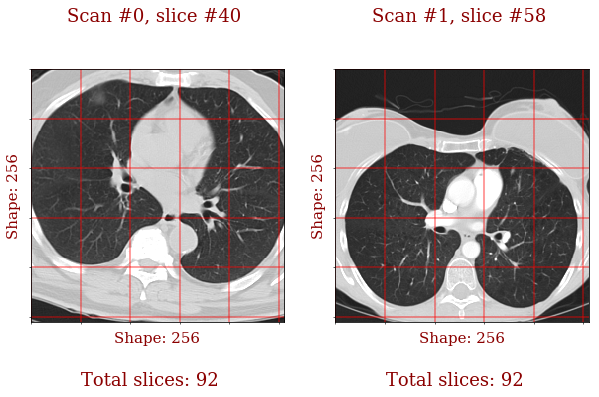

In [7]:
batch_unified = (two_scans_dataset >> preprocessing).next_batch(2, shuffle=False)
show_slices(batch_unified, scan_indices=[0, 1], ns_slice=[40, 58], grid=True)

You can see that lungs are much more similar in size, as they have the same scales. The remaining difference in sizes of lungs is explained fully by difference in dimensions of patients, participated in studies.

To get an understanding of how `unify_spacing` works, compare the same scan before and after the action:

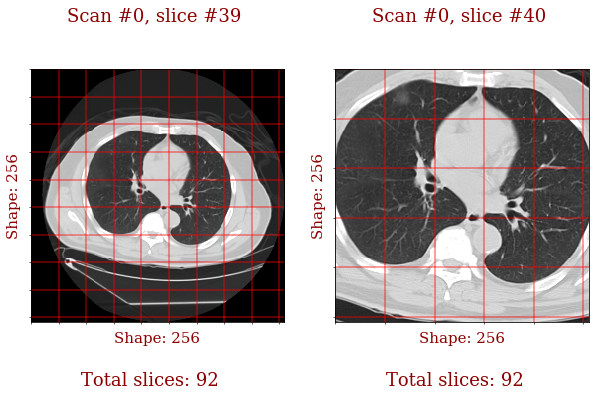

In [9]:
show_slices([batch, batch_unified], scan_indices=[0, 0], ns_slice=[39, 40], grid=True)

`unify_spacing` cropped the central part of the scan and zoomed it in, so that the new scans' spacing be equal to the supplied one (`[3.5, 1.0, 1.0]` in our case).

Essentially, `unify_spacing` is always a combination of *resize* (for manipulation with spacing) and *croping/padding* (for adjustment of shapes). Keep in mind that these parameters **should always be supplied**:

* `shape` - resulting shape of scans, sequence of three elements
* `spacing` - resulting spacing of scans, sequence of three elements

while these can be tweaked for better performance:

* `padding` - mode of padding. We recommend to use "`reflect`" (default), as it adds the least amount of artefacts. See [doc](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.pad.html) of `numpy.pad`
* `method` - choose between "`scipy`" and "`pil-simd` (default)". The first one parallelizes better on systems with large number of cores, but yields more artefacts.  

### `unify_spacing` as an augmenting action

So, how `unify_spacing` is an augmenting action? The idea is to slightly modify spacings of scans between different runs of `next_batch`. This allows to *controllably* introduce variability in the dataset. Say, you want the spacing to be randomly chosen from small set of predefined options. Assume, these options are

In [10]:
spacing_options = [(3.5, 0.5, 0.5), (3.5, 1.0, 1.0), (3.5, 1.5, 1.5), (3.5, 2.0, 2.0)]

The first step is to define *spacing randomizer*, a function that randomly fetches spacing:

In [11]:
spacing_randomizer = lambda *args: spacing_options[np.random.choice(range(len(spacing_options)))]

In [12]:
spacing_randomizer()

(3.5, 2.0, 2.0)

You can now set up the pipeline that generates random spacing for each run of `next_batch`.

In [13]:
from radio.dataset import F                                                 # see below the explanation
augmenting_pipeline = (Pipeline()                                           # empty workflow
                       .load(fmt='raw')                                     # load scans
                       .unify_spacing(spacing=F(spacing_randomizer), shape=(92, 256, 256)))

Note that spacing-parameter is set to `F(spacing_randomizer)`. Literally, this means the following: for each batch, passing through `augmenting_pipeline`, the spacing-argument is to be computed by the function `spacing_randomizer`(`F` stands for `F`unction). Pass the same batch through the workflow twice

In [14]:
np.random.seed(42)

In [15]:
batch_1 = (two_scans_dataset >> augmenting_pipeline).next_batch(2, shuffle=False)
batch_2 = (two_scans_dataset >> augmenting_pipeline).next_batch(2, shuffle=False)

...and see the result by yourself:

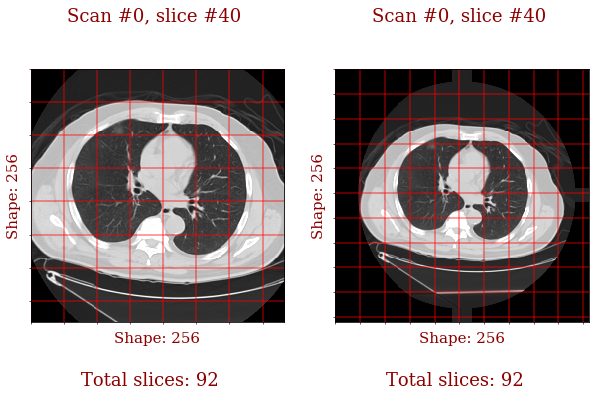

In [16]:
show_slices([batch_1, batch_2], scan_indices=[0, 0], ns_slice=[40, 40], grid=True)

### More augmenting actions: `rotate`, `central_crop`

For more augmentation you can `rotate` scans on random/specified angle, or crop out central part of scans using `central_crop`. You can of course combine these actions with others from RadIO in a single workflow:

In [17]:
augmenting_pipeline = (Pipeline()                                    # init empty workflow
                       .load(fmt='raw')                              # load data from disk
                       .resize(shape=(92, 256, 256), method='scipy') # resize with scipy
                       .rotate(angle=30, random=False)  # rotate with on 30 degrees about z-axis
                       .central_crop(crop_size=(92, 168, 168)))      # perform central_crop

Pass a batch through the pipeline:

In [18]:
batch_augmented = (two_scans_dataset >> augmenting_pipeline).next_batch(2, shuffle=False)

the effect of augmenting actions is evident, if you put the same batch through the simple preprocessing workflow and compare the results:

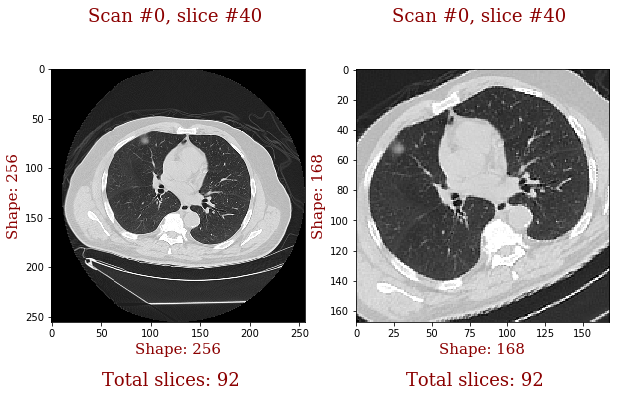

In [19]:
preprocessing_simple = (Pipeline()
                        .load(fmt='raw')
                        .resize(shape=(92, 256, 256), method='scipy'))
batch = (two_scans_dataset >> preprocessing_simple).next_batch(2, shuffle=False)
show_slices([batch, batch_augmented], [0, 0], 40, grid=False)

## Preparing a target-output for a segmenting neural network

If you followed the tutorials up to this point, you know how RadIO can help you to
* `load` scans from disk
* `resize` them to a different shape
* ..or make them more isotropic in scales with `unify_spacing`
* `rotate` them along slices-axis
* and crop out the center part using `central_crop`

However, it takes more than a bunch of preprocessing and augmenting operations to train a machine learning algorithm. As it happens, supervised learning algorithms require **target** for the learning procedure. In context of segmentation problem, target is a mask, that highlights an interesting part of an image (be it 2D as in [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html), or 3D in case of CT-scans). Lung cancer research works with *cancerous masks*: masks, with pixels values lying betweeen **0** and **1**, where **1** indicates cancer. To prepare cancerous masks with RadIO you only need to add two actions in your preprocessing workflow: `fetch_nodules_info` and `create_mask`.

### Step 1: loading info about cancerous tumors

[LUNA16 dataset](https://luna16.grand-challenge.org/) provides targets in the form of a `csv`-table, containing information about cancerous tumors (or *nodules*). Check it out by yourself:

In [20]:
import pandas as pd
nodules_df = pd.read_csv('/data/MRT/luna/CSVFILES/annotations.csv')
nodules_df.head(2)

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708


Note that each line contains information about one cancerous nodule. While `seriesuid`-column indicates the `id` of study (patient) to which the nodule is related, `coordX-Z` contain the real-world coordinates of a nodule. Finally, `diameter_mm` tells us about the real-world size of the tumor.

You can put the information from annotations-table in a batch by adding `fetch_nodules_info` to a workflow:

In [21]:
preprocessing = (Pipeline()
                 .load(fmt='raw')
                 .fetch_nodules_info(nodules_df))

pass a batch of three items through the workflow

In [22]:
batch = (luna_dataset >> preprocessing).next_batch(3, shuffle=False)

and make sure that the `batch` now contains info about nodules:

In [23]:
from utils import get_nodules_pixel_coords
get_nodules_pixel_coords(batch)            # get information about nodules from batch
                                           # in pixel coords and sizes

,numeric_ix,coordZ,coordY,coordX,diameter_pixels
0,1,113,267,185,16
1,1,141,305,365,7
2,2,112,397,155,7


### Step 2: `create_mask`

To build cancerous masks you only have to add `create_mask` to a workflow:

In [24]:
preprocessing = (Pipeline()
                 .load(fmt='raw')
                 .fetch_nodules_info(nodules_df)
                 .create_mask())

Pass a batch through the pipeline

In [25]:
batch = (luna_dataset >> preprocessing).next_batch(3, shuffle=False)

First, take a look at the nodules, that are contained in the batch:

In [26]:
get_nodules_pixel_coords(batch)

,numeric_ix,coordZ,coordY,coordX,diameter_pixels
0,1,113,267,185,16
1,1,141,305,365,7
2,2,112,397,155,7


According to the first line of the table above, there is a pretty large cancerous nodule on a slice **#113** (`coordZ`=113) of a scan indexed by **1** (`numeric_ix`=1). You can easily see it, by plotting the slice of scan and corresponding mask side by side:  

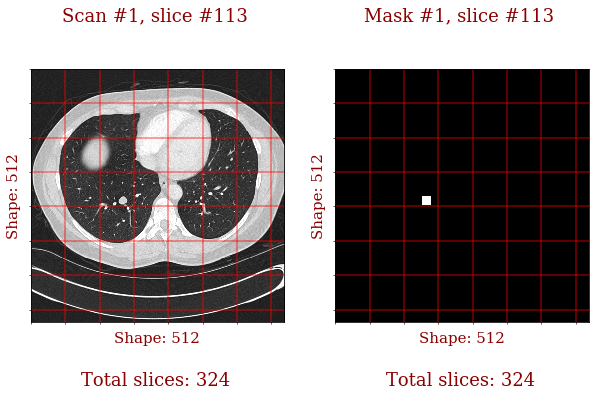

In [27]:
show_slices(batch, [1, 1], [113, 113], clims=[(-1200, 300), (0, 1)], components=['images', 'masks'])

Importantly, you can combine `resize` and `unify_spacing` just fine with `fetch_nodules_info` and `create_mask`, like that:

In [28]:
preprocessing = (Pipeline()
                 .load(fmt='raw')                     # still, start with load
                 .resize(shape=(124, 298, 298))
                 .fetch_nodules_info(nodules_df)
                 .unify_spacing(shape=(92, 256, 256), spacing=(3.5, 1.0, 1.0))
                 .create_mask()                       # should go after fetch_nodules_info()
                )

In [29]:
batch = (luna_dataset >> preprocessing).next_batch(3, shuffle=False)

In [30]:
get_nodules_pixel_coords(batch).head(1)

,numeric_ix,coordZ,coordY,coordX,diameter_pixels
0,1,32,137,77,10


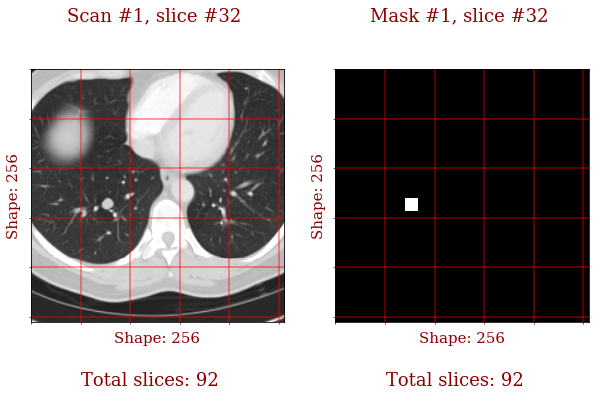

In [31]:
show_slices(batch, [1, 1], [32, 32], clims=[(-1200, 300), (0, 1)], components=['images', 'masks'])

## What's next?

After reading this tutorial you should be able to chain complex preprocessing and augmenting pipelines, that include `rotate` scans on an angle, `central_crop` and `resize`, `load`-actions, covered in the first tutorial. We've also discussed `unify_spacing`: a very useful alternative to `resize`, that not only equalizes scans' shapes, but also makes them more isotropic, zooming them to the same scale. You also should be able to make use of Luna-annotations and set up cancerous masks using `fetch_nodules_info` and `create_mask`. 

We also encourage you to stay with us for a little longer and read [3rd](https://github.com/analysiscenter/radio/blob/master/tutorials/RadIO.III.ipynb) and [4th](https://github.com/analysiscenter/radio/blob/master/tutorials/RadIO.IV.ipynb) tutorials. In the [3rd](https://github.com/analysiscenter/radio/blob/master/tutorials/RadIO.III.ipynb) tutorial you'll learn how to use action `sample_nodules` to generate batches of small (much smaller than scans) cancerous and noncancerous crops. In the [4th](https://github.com/analysiscenter/radio/blob/master/tutorials/RadIO.IV.ipynb) tutorial you will use those crops to train a zoo of powerful neural nets (including [`VNet`](https://arxiv.org/abs/1606.04797)).